# Seasonality Feature Engineering

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df_recipes = pd.read_csv('../../data/RAW_recipes.csv')
df_interactions = pd.read_csv('../../data/RAW_interactions.csv')

In [5]:
df_recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [24]:
set(df_recipes['id'].values) - set(df_interactions['recipe_id'].values)

set()

In [25]:
# df_filtered = df_interactions[df_interactions['rating'] != 0]
# recipe_stats = df_filtered.groupby('recipe_id')['rating'].agg(['mean', 'std', 'count']).reset_index()
# recipe_stats['std'] = recipe_stats['std'].fillna(0)
# top_recipes = recipe_stats.sort_values(by=['mean', 'std', 'count'], ascending=[False, True, False]).head(10)

# print(top_recipes)

In [26]:
df_interactions.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


## Approach 1: Discrete Interval (Abandoned)

In [27]:
df_recipe_interactions = pd.merge(df_recipes[['id', 'submitted']], df_interactions[['recipe_id', 'date']], how='left', left_on='id', right_on='recipe_id')

In [28]:
import pandas as pd

df_recipe_interactions['date'] = pd.to_datetime(df_recipe_interactions['date'])
df_recipe_interactions['submitted'] = pd.to_datetime(df_recipe_interactions['submitted'])

def month_to_season(month):
    if 3 <= month <= 5:
        return 1
    elif 6 <= month <= 8:
        return 2
    elif 9 <= month <= 11:
        return 3
    else:
        return 4

df_recipe_interactions['interaction_season'] = df_recipe_interactions['date'].dt.month.apply(month_to_season)
df_recipe_interactions['submitted_season'] = df_recipe_interactions['submitted'].dt.month.apply(month_to_season)

interaction_season_counts = (
    df_recipe_interactions.groupby(['recipe_id', 'interaction_season'])
    .size()
    .unstack(fill_value=0)
)

interaction_season_ratios = interaction_season_counts.div(interaction_season_counts.sum(axis=1), axis=0)
interaction_season_ratios = interaction_season_ratios.rename_axis(None, axis=1).reset_index()
interaction_season_ratios.columns = ['recipe_id'] + [f'interaction_season_{c}' for c in interaction_season_ratios.columns[1:]]

interactions_count = df_recipe_interactions.groupby('recipe_id').size().reset_index(name='interactions_count')
interaction_season_ratios = interaction_season_ratios.merge(interactions_count, on='recipe_id', how='left')

submitted_season_counts = (
    df_recipe_interactions.groupby(['recipe_id', 'submitted_season'])
    .size()
    .unstack(fill_value=0)
)

submitted_season_ratios = submitted_season_counts.div(submitted_season_counts.sum(axis=1), axis=0)
submitted_season_ratios = submitted_season_ratios.rename_axis(None, axis=1).reset_index()
submitted_season_ratios.columns = ['recipe_id'] + [f'submitted_season_{c}' for c in submitted_season_ratios.columns[1:]]

submitted_count = df_recipe_interactions.groupby('recipe_id')['submitted'].nunique().reset_index(name='submitted_count')
recipe_season_stats = submitted_season_ratios.merge(interaction_season_ratios, on='recipe_id')

In [29]:
recipe_season_stats

,recipe_id,submitted_season_1,submitted_season_2,submitted_season_3,submitted_season_4,interaction_season_1,interaction_season_2,interaction_season_3,interaction_season_4,interactions_count
0,38,0.0,1.0,0.0,0.0,0.000000,0.500000,0.000000,0.500000,4
1,39,0.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,1.000000,1
2,40,0.0,0.0,1.0,0.0,0.111111,0.333333,0.111111,0.444444,9
3,41,0.0,0.0,1.0,0.0,0.500000,0.000000,0.000000,0.500000,2
4,43,0.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,1.000000,1
...,...,...,...,...,...,...,...,...,...,...
231632,537459,0.0,0.0,1.0,0.0,0.000000,0.000000,1.000000,0.000000,1
231633,537485,0.0,0.0,1.0,0.0,0.000000,0.000000,1.000000,0.000000,1
231634,537543,0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,1.000000,1
231635,537671,0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,1.000000,1


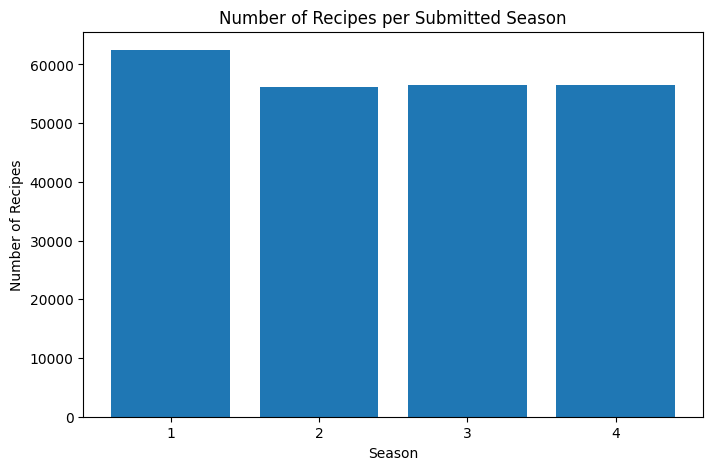

In [30]:
season_cols = [col for col in submitted_season_ratios.columns if col.startswith('submitted_season_')]
season_counts = submitted_season_ratios[season_cols].sum()

seasons = [col.split('_')[-1] for col in season_counts.index]

plt.figure(figsize=(8, 5))
plt.bar(seasons, season_counts.values)
plt.xlabel('Season')
plt.ylabel('Number of Recipes')
plt.title('Number of Recipes per Submitted Season')
plt.show()

In [31]:
df_recipes[df_recipes['id'] == 27208]

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
213826,to die for crock pot roast,27208,545,28201,2002-05-03,"['weeknight', 'time-to-make', 'course', 'main-...","[295.2, 14.0, 0.0, 15.0, 99.0, 19.0, 0.0]",7,"['place beef roast in crock pot', 'mix the dri...","amazing flavor, and so simple! no salt needed ...","['beef roast', 'brown gravy mix', 'dried itali...",5


In [32]:
df_interactions[df_interactions['recipe_id'] == 27208]

,user_id,recipe_id,date,rating,review
634084,103224,27208,2004-10-25,5,Can't add anything that hasn't already been sa...
655724,191436,27208,2005-02-23,5,Perfection!! The best roast I have ever made. ...
655770,41218,27208,2002-06-08,4,"I was expecting more, I guess due to the name...."
655864,37022,27208,2002-06-04,3,"Sorry, but this was just WAY TO SALTY for my f..."
655880,39194,27208,2002-05-04,0,"Being a single guy, this is right up my alley!..."
...,...,...,...,...,...
657552,2001921182,27208,2018-10-17,5,This is very similar to &quot;Mississippi Potr...
657553,2002275307,27208,2018-10-21,5,"Followed the recipe, and it was the best roast..."
657554,2002236201,27208,2018-10-23,3,"It was good, but nothing outstanding about it...."
657555,2001346577,27208,2018-10-25,5,I've tried so many pot roast recipes but never...


In [33]:
recipe_season_stats[recipe_season_stats['recipe_id'] == 27208].sort_values(by='interactions_count', ascending=False)

,recipe_id,submitted_season_1,submitted_season_2,submitted_season_3,submitted_season_4,interaction_season_1,interaction_season_2,interaction_season_3,interaction_season_4,interactions_count
14424,27208,1.0,0.0,0.0,0.0,0.180512,0.217989,0.30356,0.297939,1601


## Approach 2: Trigonometric Transformation + Bayesian Smoothing

### Trigonometric transformation for periodicity

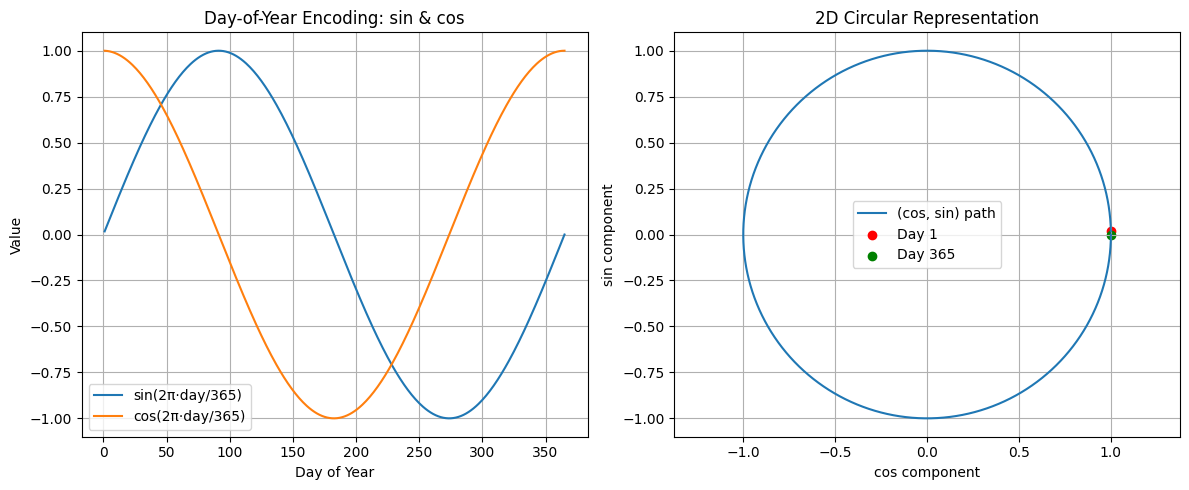

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Days of year
days = np.arange(1, 366)

# Encode as sin and cos
x_sin = np.sin(2 * np.pi * days / 365)
x_cos = np.cos(2 * np.pi * days / 365)

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(days, x_sin, label='sin(2π·day/365)')
plt.plot(days, x_cos, label='cos(2π·day/365)')
plt.title('Day-of-Year Encoding: sin & cos')
plt.xlabel('Day of Year')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# 2D plot to visualize the circular encoding
plt.subplot(1, 2, 2)
plt.plot(x_cos, x_sin, label='(cos, sin) path')
plt.scatter([x_cos[0]], [x_sin[0]], color='red', label='Day 1')
plt.scatter([x_cos[-1]], [x_sin[-1]], color='green', label='Day 365')
plt.axis('equal')
plt.title('2D Circular Representation')
plt.xlabel('cos component')
plt.ylabel('sin component')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [35]:
df_recipes['submitted'] = pd.to_datetime(df_recipes['submitted'])
df_recipes['submitted_doy'] = df_recipes['submitted'].dt.dayofyear
df_recipes['submitted_doy_sin'] = np.sin(2 * np.pi * df_recipes['submitted_doy'] / 365)
df_recipes['submitted_doy_cos'] = np.cos(2 * np.pi * df_recipes['submitted_doy'] / 365)

In [36]:
df_interactions.groupby('recipe_id')['date'].count().describe()

count    231637.000000
mean          4.888541
std          17.532481
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max        1613.000000
Name: date, dtype: float64

### Bayesian smoothing for small example size problem

<Axes: >

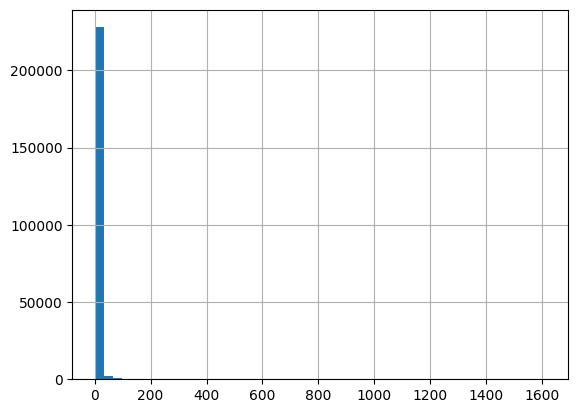

In [37]:
recipe_season_stats['interactions_count'].hist(bins=50)

Bayesian smoothing (or Empirical Bayes smoothing) is a technique used to adjust noisy estimates—especially those based on small sample sizes—by "shrinking" them toward a global or prior mean. It balances the local estimate (based on the specific group's data) with a global estimate (based on the entire dataset), weighted by their respective sample sizes.

Small-sample estimates are pulled strongly toward the global mean (to reduce variance), while large-sample estimates remain close to their original values (to preserve information). This helps stabilize metrics and prevents extreme values caused by random noise.

$
\sin_{\text{smooth}} = 
\frac{n \cdot \overline{\sin} + k \cdot \sin_{\text{global}}}{n + k}
$

$\cos_{\text{smooth}} = 
\frac{n \cdot \overline{\cos} + k \cdot \cos_{\text{global}}}{n + k}
$

In [80]:
# Convert date to day-of-year and create sine/cosine cyclical features
df_interactions['date'] = pd.to_datetime(df_interactions['date'])
df_interactions['date_doy'] = df_interactions['date'].dt.dayofyear
df_interactions['date_doy_sin'] = np.sin(2 * np.pi * df_interactions['date_doy'] / 365)
df_interactions['date_doy_cos'] = np.cos(2 * np.pi * df_interactions['date_doy'] / 365)

# Aggregate by recipe_id: mean sine/cosine values and count of interactions
df_interactions_date_doy_features = df_interactions.groupby('recipe_id').agg(
    inter_doy_sin_mean=('date_doy_sin', 'mean'),
    inter_doy_cos_mean=('date_doy_cos', 'mean'),
    n=('date_doy_sin', 'size')
).reset_index()

# Compute global mean sine/cosine for smoothing
sin_global = df_interactions['date_doy_sin'].mean()
cos_global = df_interactions['date_doy_cos'].mean()

# Apply empirical Bayes smoothing to sine and cosine features
k = 10  # smoothing strength (pseudo count) -> trade-off between information richness and stability
df_interactions_date_doy_features['inter_doy_sin_smooth'] = (
    df_interactions_date_doy_features['n'] * df_interactions_date_doy_features['inter_doy_sin_mean'] + k * sin_global
) / (df_interactions_date_doy_features['n'] + k)

df_interactions_date_doy_features['inter_doy_cos_smooth'] = (
    df_interactions_date_doy_features['n'] * df_interactions_date_doy_features['inter_doy_cos_mean'] + k * cos_global
) / (df_interactions_date_doy_features['n'] + k)

# Compute seasonal strength (resultant vector length)
df_interactions_date_doy_features['inter_strength'] = np.sqrt(
    df_interactions_date_doy_features['inter_doy_sin_smooth']**2 + 
    df_interactions_date_doy_features['inter_doy_cos_smooth']**2
)

# Compute log(count) to represent interaction volume / reliability
df_interactions_date_doy_features['log_n_inter'] = np.log1p(df_interactions_date_doy_features['n'])

print(df_interactions_date_doy_features.head())

   recipe_id  inter_doy_sin_mean  inter_doy_cos_mean  n  inter_doy_sin_smooth  \
0         38           -0.020995            0.005646  4              0.005644   
1         39            0.337523            0.941317  1              0.045501   
2         40            0.037343            0.111744  9              0.026267   
3         41            0.706195            0.350306  2              0.131282   
4         43            0.608477            0.793572  1              0.070133   

   inter_doy_cos_smooth  inter_strength  log_n_inter  
0              0.019408        0.020212     1.609438  
1              0.108223        0.117399     0.693147  
2              0.066044        0.071076     2.302585  
3              0.079145        0.153293     1.098612  
4              0.094791        0.117916     0.693147  


<Axes: >

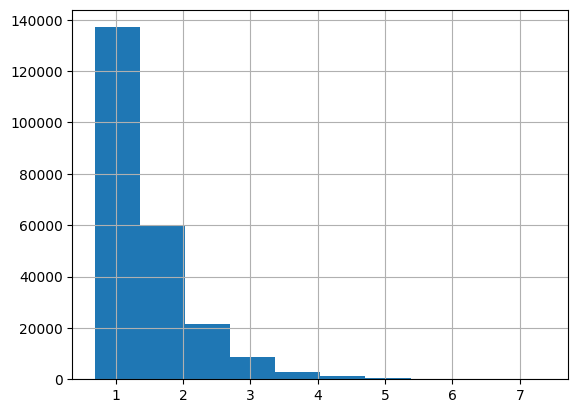

In [81]:
df_interactions_date_doy_features['log_n_inter'].hist()

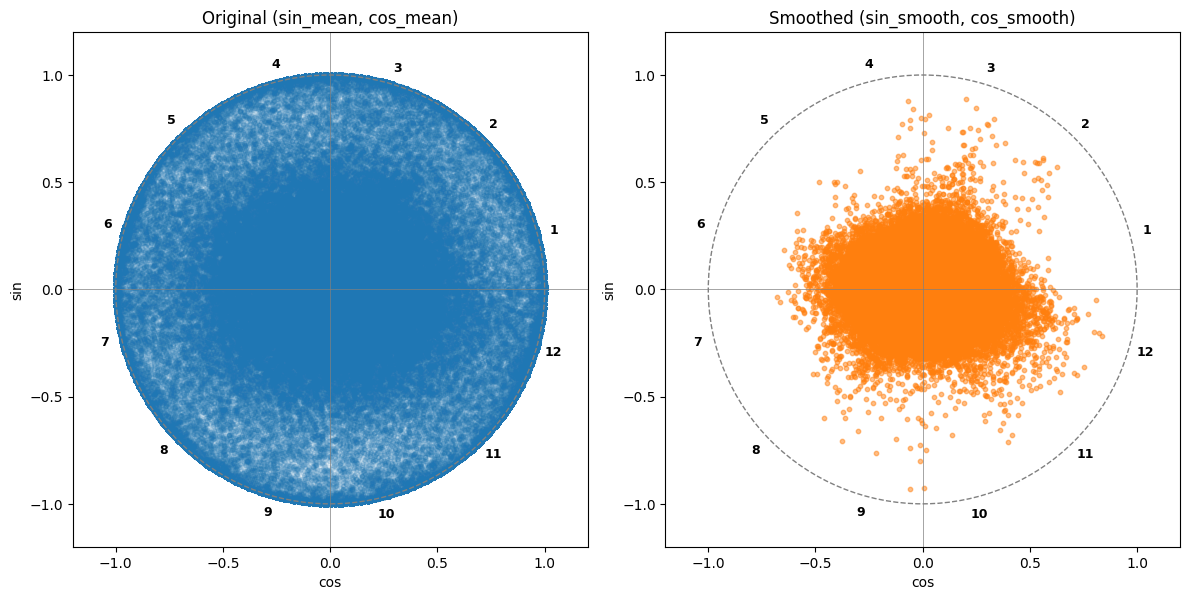

In [82]:
import matplotlib.pyplot as plt
import numpy as np

axis_lim = 1.2

def add_month_labels(ax):
    """Add month labels (1–12) around the unit circle."""
    # approximate middle day-of-year for each month (non-leap year)
    month_mid_doy = [15, 46, 74, 105, 135, 166, 196, 227, 258, 288, 319, 349]
    for month, doy in enumerate(month_mid_doy, start=1):
        theta = 2 * np.pi * doy / 365
        x = np.cos(theta) * 1.08
        y = np.sin(theta) * 1.08
        ax.text(x, y, str(month), ha='center', va='center', fontsize=9, fontweight='bold')

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Left: Original mean vectors
ax = axes[0]
ax.scatter(
    df_interactions_date_doy_features['inter_doy_cos_mean'],
    df_interactions_date_doy_features['inter_doy_sin_mean'],
    s=10, alpha=0.1
)
circle = plt.Circle((0, 0), 1, color='grey', fill=False, linestyle='--')
ax.add_artist(circle)
ax.axhline(0, color='grey', lw=0.5)
ax.axvline(0, color='grey', lw=0.5)
ax.set_aspect('equal', 'box')
ax.set_xlim(-axis_lim, axis_lim)
ax.set_ylim(-axis_lim, axis_lim)
ax.set_title('Original (sin_mean, cos_mean)')
ax.set_xlabel('cos')
ax.set_ylabel('sin')
add_month_labels(ax)

# Right: Smoothed mean vectors
ax = axes[1]
ax.scatter(
    df_interactions_date_doy_features['inter_doy_cos_smooth'],
    df_interactions_date_doy_features['inter_doy_sin_smooth'],
    s=10, alpha=0.5, color='tab:orange'
)
circle = plt.Circle((0, 0), 1, color='grey', fill=False, linestyle='--')
ax.add_artist(circle)
ax.axhline(0, color='grey', lw=0.5)
ax.axvline(0, color='grey', lw=0.5)
ax.set_aspect('equal', 'box')
ax.set_xlim(-axis_lim, axis_lim)
ax.set_ylim(-axis_lim, axis_lim)
ax.set_title('Smoothed (sin_smooth, cos_smooth)')
ax.set_xlabel('cos')
ax.set_ylabel('sin')
add_month_labels(ax)

plt.tight_layout()
plt.show()

In our recipe interactions data, some recipes only have a couple of interaction dates — like one or two — while others have hundreds. If we just take the average sine and cosine of the interaction dates for each recipe, the small-sample ones end up being super noisy. With only one interaction, the recipe's "season" basically lands on a random point on the unit circle.

Bayesian smoothing helps fix that. It blends each recipe's seasonal signal with the overall average across all recipes. So recipes with very few interactions get pulled toward the global mean — toward the center of the circle — which reduces random noise. Recipes with lots of data keep their own seasonal pattern. The result is a set of seasonal features that's much more stable and meaningful, which makes clustering or modeling downstream a lot more reliable.

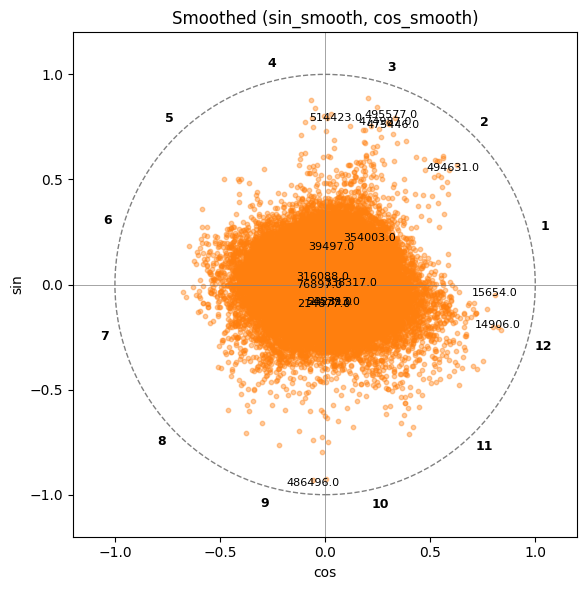

In [51]:
#### import matplotlib.pyplot as plt
import numpy as np

axis_lim = 1.2

def add_month_labels(ax):
    """Add month labels (1–12) around the unit circle."""
    month_mid_doy = [15, 46, 74, 105, 135, 166, 196, 227, 258, 288, 319, 349]
    for month, doy in enumerate(month_mid_doy, start=1):
        theta = 2 * np.pi * doy / 365
        x = np.cos(theta) * 1.08
        y = np.sin(theta) * 1.08
        ax.text(x, y, str(month), ha='center', va='center', fontsize=9, fontweight='bold')

# --- Plot only the smoothed points ---
fig, ax = plt.subplots(figsize=(6, 6))

# Scatter plot of all smoothed vectors
ax.scatter(
    df_interactions_date_doy_features['inter_doy_cos_smooth'],
    df_interactions_date_doy_features['inter_doy_sin_smooth'],
    s=10, alpha=0.4, color='tab:orange'
)

# Draw unit circle and axes
circle = plt.Circle((0, 0), 1, color='grey', fill=False, linestyle='--')
ax.add_artist(circle)
ax.axhline(0, color='grey', lw=0.5)
ax.axvline(0, color='grey', lw=0.5)
ax.set_aspect('equal', 'box')
ax.set_xlim(-axis_lim, axis_lim)
ax.set_ylim(-axis_lim, axis_lim)
ax.set_title('Smoothed (sin_smooth, cos_smooth)')
ax.set_xlabel('cos')
ax.set_ylabel('sin')

# Add month labels
add_month_labels(ax)

# --- Stratified sampling based on strength ---
n_labels_inner = 8  # number of labels from inner circle
n_labels_outer = 8  # number of labels from outer circle

# Compute strength if not already available
if 'strength' not in df_interactions_date_doy_features.columns:
    df_interactions_date_doy_features['strength'] = np.sqrt(
        df_interactions_date_doy_features['inter_doy_sin_smooth']**2 +
        df_interactions_date_doy_features['inter_doy_cos_smooth']**2
    )

# Define thresholds or quantiles
inner_candidates = df_interactions_date_doy_features.query('strength < 0.4')
outer_candidates = df_interactions_date_doy_features.query('strength > 0.8')

inner_sample = inner_candidates.sample(n=min(n_labels_inner, len(inner_candidates)), random_state=42)
outer_sample = outer_candidates.sample(n=min(n_labels_outer, len(outer_candidates)), random_state=42)

label_sample = pd.concat([inner_sample, outer_sample])

# --- Label selected points ---
for _, row in label_sample.iterrows():
    x = row['inter_doy_cos_smooth']
    y = row['inter_doy_sin_smooth']
    recipe_id = row['recipe_id']
    ax.text(
        x + np.random.uniform(-0.02, 0.02),
        y + np.random.uniform(-0.02, 0.02),
        str(recipe_id),
        fontsize=8,
        ha='center',
        va='center'
    )

plt.tight_layout()
plt.show()

In [42]:
df_recipes_with_season_features = pd.merge(df_recipes, df_interactions_date_doy_features, left_on='id', right_on='recipe_id').drop(['recipe_id'], axis=1)

In [52]:
df_recipes_with_season_features[df_recipes_with_season_features['id'].isin([15654])]

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,submitted_doy_cos,inter_doy_sin_mean,inter_doy_cos_mean,n,inter_doy_sin_smooth,inter_doy_cos_smooth,inter_strength,log_n_inter,strength,cluster
151305,overnight eggnog baked french toast,15654,40,4470,2001-12-12,"['60-minutes-or-less', 'time-to-make', 'course...","[303.3, 26.0, 75.0, 10.0, 25.0, 44.0, 8.0]",6,"['beat together eggs , eggnog , rum , sugar , ...","another do ahead, enjoy your family & guests r...",...,0.946988,-0.061098,0.92484,67,-0.051046,0.807966,0.809577,4.219508,0.809577,0


In [53]:
df_interactions[df_interactions['recipe_id'] == 15654]

,user_id,recipe_id,date,rating,review,date_doy,date_doy_sin,date_doy_cos
1029305,59886,15654,2003-01-13,5,Yum! I made this for Christmas morning breakf...,13,2.219215e-01,0.975065
1029536,2312,15654,2001-12-26,5,"Mmmm, French toast and egg nog: two great tast...",360,-8.596480e-02,0.996298
1029537,27858,15654,2002-01-03,5,This is a very delicious dish. I made a simila...,3,5.161967e-02,0.998667
1029538,56087,15654,2002-12-23,5,This was a fantastic treat. I have actually m...,357,-1.372788e-01,0.990532
1029539,31232,15654,2003-01-01,5,Excellent easy breakfast. I popped it in the ...,1,1.721336e-02,0.999852
...,...,...,...,...,...,...,...,...
1029690,294000,15654,2014-12-25,5,Enjoyed this very much on Christmas morning. I...,359,-1.031017e-01,0.994671
1029691,140132,15654,2014-12-28,5,I made this for our Christmas breakfast. It w...,362,-5.161967e-02,0.998667
1029692,2000552739,15654,2015-10-12,5,I made this (Saturday night for Sunday brunch)...,285,-9.813065e-01,0.192452
1029693,1849811,15654,2015-12-25,5,Perfect holiday breakfast recipe. Make it nig...,359,-1.031017e-01,0.994671


### Correlation between submitted_doy and inter_doy

In [56]:
corr_sin = df_recipes_with_season_features['submitted_doy_sin'].corr(df_recipes_with_season_features['inter_doy_sin_smooth'])
corr_cos = df_recipes_with_season_features['submitted_doy_cos'].corr(df_recipes_with_season_features['inter_doy_cos_smooth'])
print(f"Correlation (sin): {corr_sin:.3f}")
print(f"Correlation (cos): {corr_cos:.3f}")

Correlation (sin): 0.188
Correlation (cos): 0.232


In [58]:
# Convert sin/cos to angles in radians
theta_submitted = np.arctan2(df_recipes_with_season_features['submitted_doy_sin'], df_recipes_with_season_features['submitted_doy_cos'])
theta_inter = np.arctan2(df_recipes_with_season_features['inter_doy_sin_smooth'], df_recipes_with_season_features['inter_doy_cos_smooth'])

# Compute angular difference in [-pi, pi], then convert to absolute value
angle_diff = np.angle(np.exp(1j * (theta_inter - theta_submitted)))

# Convert to degrees for interpretability
angle_diff_deg = np.degrees(np.abs(angle_diff))

df_recipes_with_season_features['angle_diff_deg'] = angle_diff_deg

print(df_recipes_with_season_features['angle_diff_deg'].describe())

count    231637.000000
mean         75.328545
std          52.384831
min           0.000450
25%          28.615691
50%          67.123512
75%         118.651244
max         179.999232
Name: angle_diff_deg, dtype: float64


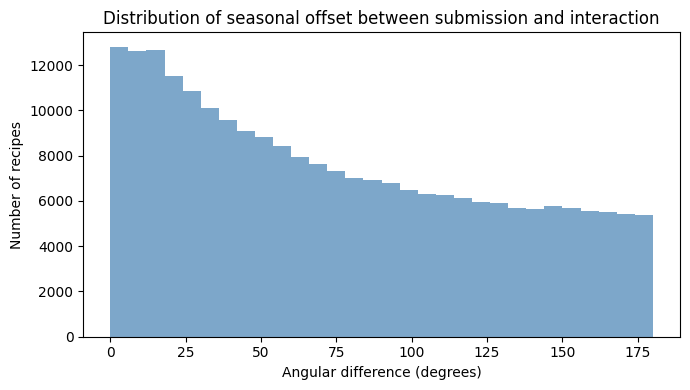

In [60]:
plt.figure(figsize=(7,4))
plt.hist(df_recipes_with_season_features['angle_diff_deg'], bins=30, alpha=0.7, color='steelblue')
plt.xlabel('Angular difference (degrees)')
plt.ylabel('Number of recipes')
plt.title('Distribution of seasonal offset between submission and interaction')
plt.tight_layout()
plt.show()

### Season-features clustering analysis

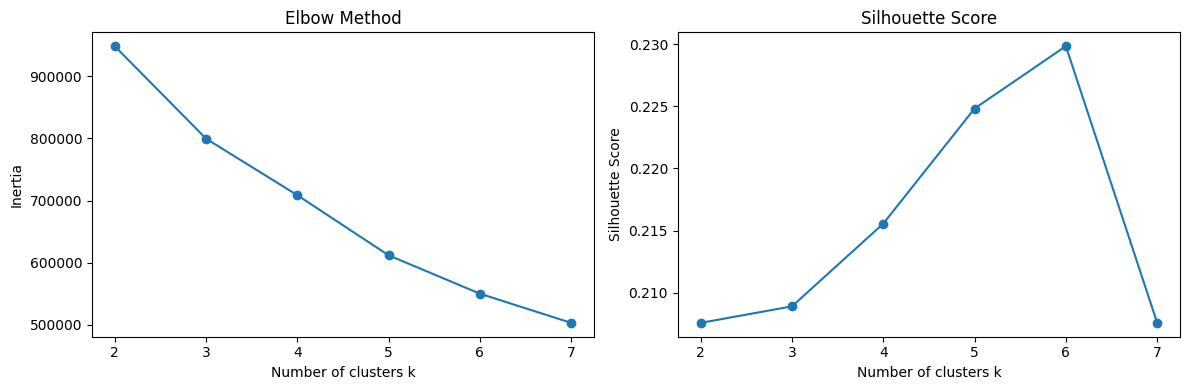

Best k (by silhouette score): 6


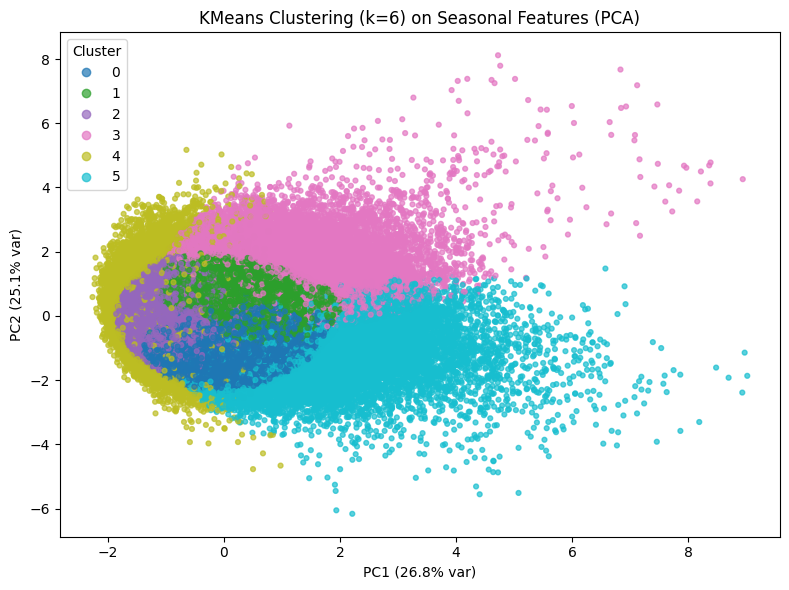


Cluster feature means:
          submitted_doy_sin  submitted_doy_cos  inter_doy_sin_smooth  \
cluster                                                               
0                -0.825353          -0.037886             -0.002860   
1                 0.449320           0.704160              0.025371   
2                 0.443642          -0.708158              0.006235   
3                 0.338408           0.336422              0.181470   
4                 0.193500          -0.473739             -0.033926   
5                -0.406050           0.222360             -0.074623   

         inter_doy_cos_smooth  inter_strength  
cluster                                        
0                    0.029101        0.101090  
1                    0.024403        0.099950  
2                   -0.005994        0.097051  
3                    0.050271        0.217255  
4                   -0.211457        0.255315  
5                    0.203200        0.245922  

Correlation between c

In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Select features for clustering
features = [
    'submitted_doy_sin',
    'submitted_doy_cos',
    'inter_doy_sin_smooth',
    'inter_doy_cos_smooth',
    'inter_strength'
]

X = df_recipes_with_season_features[features].copy()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Find the optimal number of clusters (Elbow + Silhouette)
inertias = []
sil_scores = []
K_range = range(2, 8)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    try:
        score = silhouette_score(X_scaled, labels)
    except:
        score = np.nan
    sil_scores.append(score)

# 4. Plot Elbow and Silhouette curves
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(K_range, inertias, '-o')
ax[0].set_xlabel('Number of clusters k')
ax[0].set_ylabel('Inertia')
ax[0].set_title('Elbow Method')

ax[1].plot(K_range, sil_scores, '-o')
ax[1].set_xlabel('Number of clusters k')
ax[1].set_ylabel('Silhouette Score')
ax[1].set_title('Silhouette Score')

plt.tight_layout()
plt.show()

# Choose the best k based on the highest silhouette score
valid_scores = np.array(sil_scores)
best_k = K_range[np.nanargmax(valid_scores)]
print(f"Best k (by silhouette score): {best_k}")

# Fit KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
labels = kmeans.fit_predict(X_scaled)
df_recipes_with_season_features['cluster'] = labels

# PCA for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

df_plot = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_plot['cluster'] = labels

# Plot clusters on PCA-reduced space
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df_plot['PC1'],
    df_plot['PC2'],
    c=df_plot['cluster'],
    cmap='tab10',
    s=12,
    alpha=0.7
)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} var)")
plt.title(f'KMeans Clustering (k={best_k}) on Seasonal Features (PCA)')
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.tight_layout()
plt.show()

# Examine mean feature values per cluster
cluster_summary = df_recipes_with_season_features.groupby('cluster')[features].mean()
print("\nCluster feature means:\n", cluster_summary)

# Compute correlations between cluster assignments and each feature
# Convert cluster labels to dummy variables for correlation analysis
cluster_dummies = pd.get_dummies(df_recipes_with_season_features['cluster'], prefix='cluster')
corr_matrix = pd.concat([cluster_dummies, df_recipes_with_season_features[features]], axis=1).corr()

# Extract only correlations between clusters and features
cluster_feature_corr = corr_matrix.loc[cluster_dummies.columns, features]
print("\nCorrelation between clusters and original features:\n")
print(cluster_feature_corr.round(3))

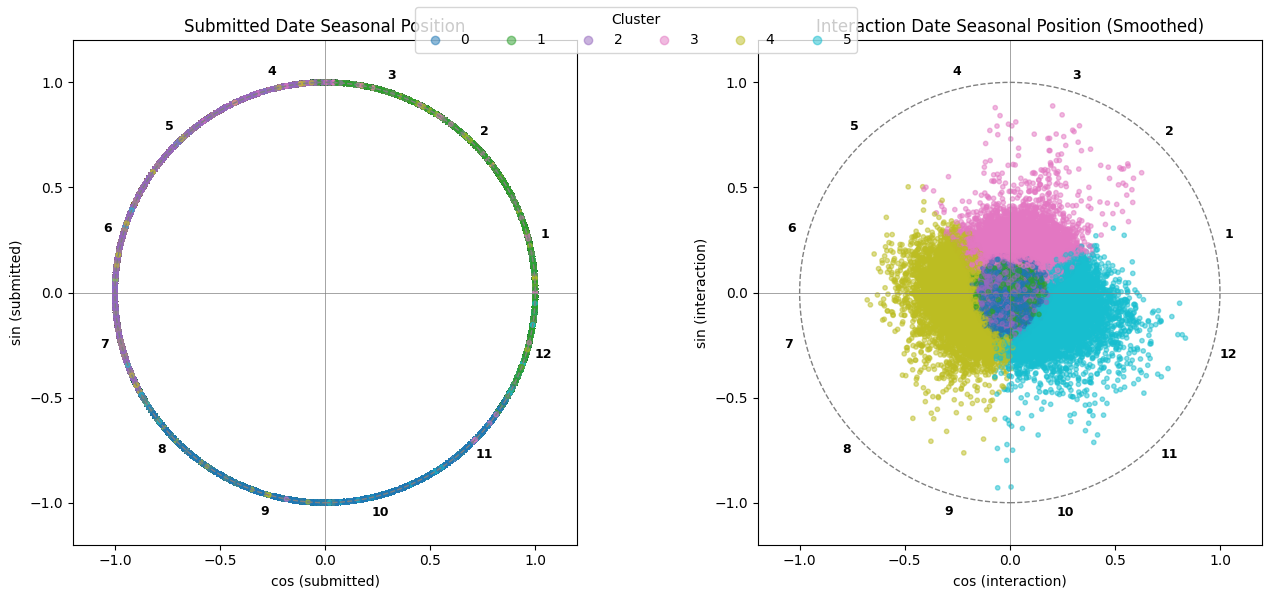

In [66]:
# Data
df = df_recipes_with_season_features.copy()
axis_lim = 1.2

# Create figure with 2 subplots (submitted vs interaction)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: Submitted seasonal position
ax = axes[0]
scatter1 = ax.scatter(
    df['submitted_doy_cos'],
    df['submitted_doy_sin'],
    c=df['cluster'],
    cmap='tab10',
    s=10,
    alpha=0.5
)
circle = plt.Circle((0, 0), 1, color='grey', fill=False, linestyle='--')
ax.add_artist(circle)
ax.axhline(0, color='grey', lw=0.5)
ax.axvline(0, color='grey', lw=0.5)
ax.set_aspect('equal', 'box')
ax.set_xlim(-axis_lim, axis_lim)
ax.set_ylim(-axis_lim, axis_lim)
ax.set_xlabel('cos (submitted)')
ax.set_ylabel('sin (submitted)')
ax.set_title('Submitted Date Seasonal Position')
add_month_labels(ax)

# Right plot: Interaction seasonal position (smoothed)
ax = axes[1]
scatter2 = ax.scatter(
    df['inter_doy_cos_smooth'],
    df['inter_doy_sin_smooth'],
    c=df['cluster'],
    cmap='tab10',
    s=10,
    alpha=0.5
)
circle = plt.Circle((0, 0), 1, color='grey', fill=False, linestyle='--')
ax.add_artist(circle)
ax.axhline(0, color='grey', lw=0.5)
ax.axvline(0, color='grey', lw=0.5)
ax.set_aspect('equal', 'box')
ax.set_xlim(-axis_lim, axis_lim)
ax.set_ylim(-axis_lim, axis_lim)
ax.set_xlabel('cos (interaction)')
ax.set_ylabel('sin (interaction)')
ax.set_title('Interaction Date Seasonal Position (Smoothed)')
add_month_labels(ax)

# Add legend for clusters
fig.legend(*scatter1.legend_elements(), title="Cluster", loc="upper center", ncol=len(df['cluster'].unique()))
plt.tight_layout()
plt.show()

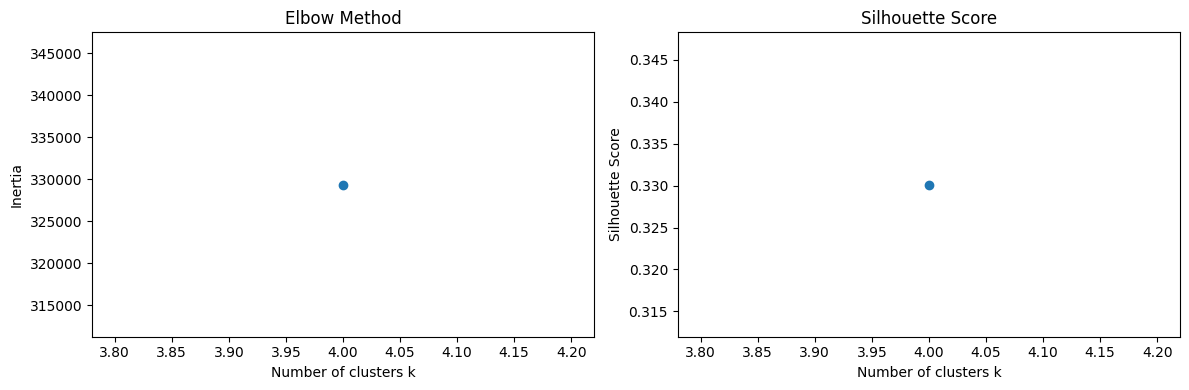

Best k (by silhouette score): 4


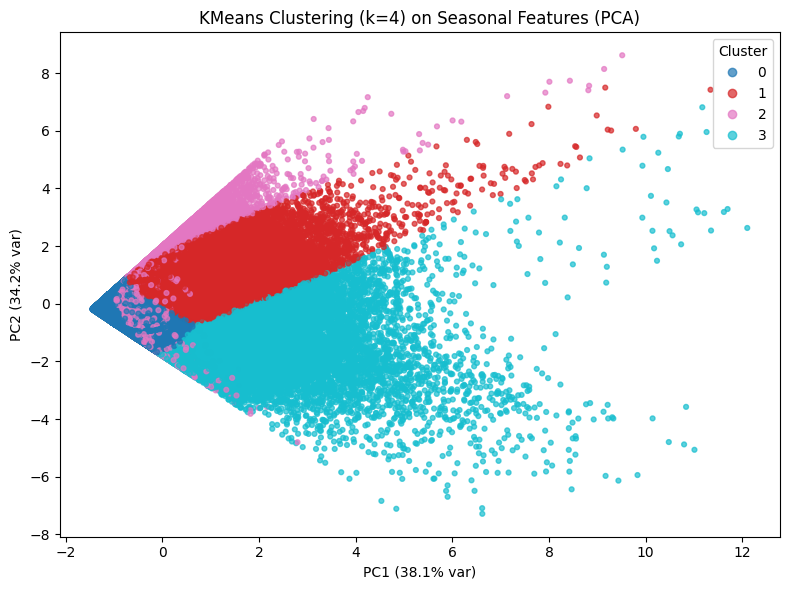


Cluster feature means:
          inter_doy_sin_smooth  inter_doy_cos_smooth  inter_strength
cluster                                                            
0                   -0.032833              0.006464        0.084535
1                    0.108655              0.038374        0.136678
2                   -0.000035             -0.188376        0.226955
3                   -0.056044              0.191934        0.232993

Correlation between clusters and original features:

           inter_doy_sin_smooth  inter_doy_cos_smooth  inter_strength
cluster_0                -0.460                -0.120          -0.571
cluster_1                 0.675                 0.118           0.060
cluster_2                -0.051                -0.582           0.395
cluster_3                -0.252                 0.539           0.474


In [71]:
# Select features for clustering
features = [
    'inter_doy_sin_smooth',
    'inter_doy_cos_smooth',
    'inter_strength'
]

X = df_recipes_with_season_features[features].copy()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Find the optimal number of clusters (Elbow + Silhouette)
inertias = []
sil_scores = []
# K_range = range(2, 8)
K_range = [4]

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    try:
        score = silhouette_score(X_scaled, labels)
    except:
        score = np.nan
    sil_scores.append(score)

# 4. Plot Elbow and Silhouette curves
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(K_range, inertias, '-o')
ax[0].set_xlabel('Number of clusters k')
ax[0].set_ylabel('Inertia')
ax[0].set_title('Elbow Method')

ax[1].plot(K_range, sil_scores, '-o')
ax[1].set_xlabel('Number of clusters k')
ax[1].set_ylabel('Silhouette Score')
ax[1].set_title('Silhouette Score')

plt.tight_layout()
plt.show()

# Choose the best k based on the highest silhouette score
valid_scores = np.array(sil_scores)
best_k = K_range[np.nanargmax(valid_scores)]
print(f"Best k (by silhouette score): {best_k}")

# Fit KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
labels = kmeans.fit_predict(X_scaled)
df_recipes_with_season_features['cluster'] = labels

# PCA for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

df_plot = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_plot['cluster'] = labels

# Plot clusters on PCA-reduced space
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df_plot['PC1'],
    df_plot['PC2'],
    c=df_plot['cluster'],
    cmap='tab10',
    s=12,
    alpha=0.7
)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} var)")
plt.title(f'KMeans Clustering (k={best_k}) on Seasonal Features (PCA)')
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.tight_layout()
plt.show()

# Examine mean feature values per cluster
cluster_summary = df_recipes_with_season_features.groupby('cluster')[features].mean()
print("\nCluster feature means:\n", cluster_summary)

# Compute correlations between cluster assignments and each feature
# Convert cluster labels to dummy variables for correlation analysis
cluster_dummies = pd.get_dummies(df_recipes_with_season_features['cluster'], prefix='cluster')
corr_matrix = pd.concat([cluster_dummies, df_recipes_with_season_features[features]], axis=1).corr()

# Extract only correlations between clusters and features
cluster_feature_corr = corr_matrix.loc[cluster_dummies.columns, features]
print("\nCorrelation between clusters and original features:\n")
print(cluster_feature_corr.round(3))

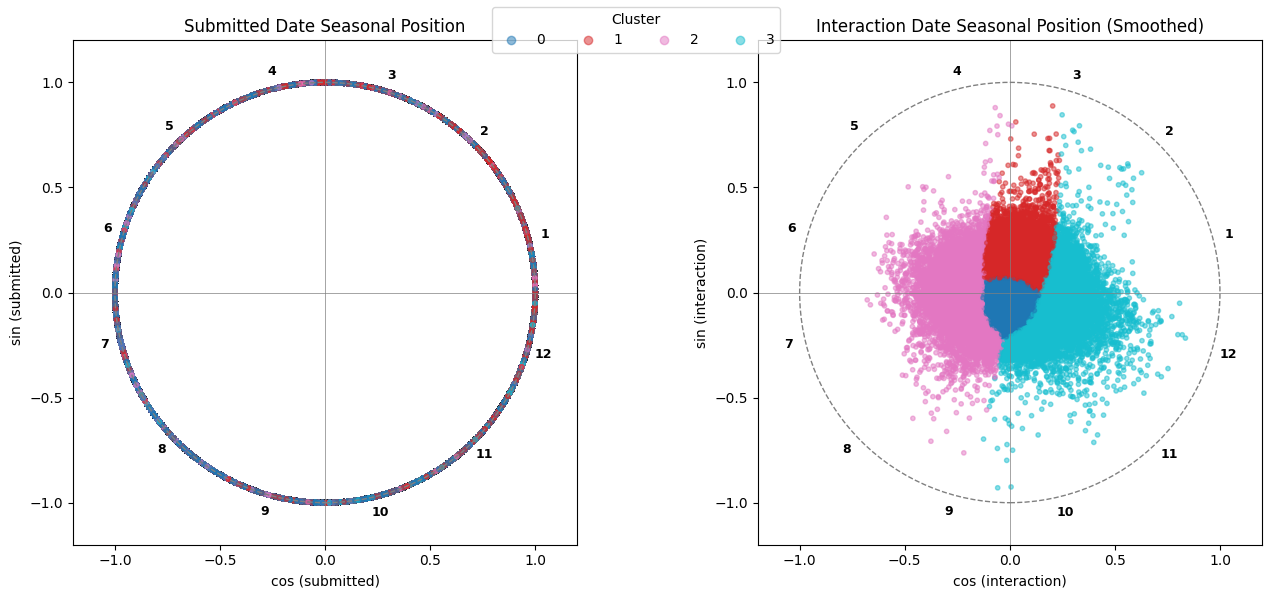

In [72]:
# Data
df = df_recipes_with_season_features.copy()
axis_lim = 1.2

# Create figure with 2 subplots (submitted vs interaction)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: Submitted seasonal position
ax = axes[0]
scatter1 = ax.scatter(
    df['submitted_doy_cos'],
    df['submitted_doy_sin'],
    c=df['cluster'],
    cmap='tab10',
    s=10,
    alpha=0.5
)
circle = plt.Circle((0, 0), 1, color='grey', fill=False, linestyle='--')
ax.add_artist(circle)
ax.axhline(0, color='grey', lw=0.5)
ax.axvline(0, color='grey', lw=0.5)
ax.set_aspect('equal', 'box')
ax.set_xlim(-axis_lim, axis_lim)
ax.set_ylim(-axis_lim, axis_lim)
ax.set_xlabel('cos (submitted)')
ax.set_ylabel('sin (submitted)')
ax.set_title('Submitted Date Seasonal Position')
add_month_labels(ax)

# Right plot: Interaction seasonal position (smoothed)
ax = axes[1]
scatter2 = ax.scatter(
    df['inter_doy_cos_smooth'],
    df['inter_doy_sin_smooth'],
    c=df['cluster'],
    cmap='tab10',
    s=10,
    alpha=0.5
)
circle = plt.Circle((0, 0), 1, color='grey', fill=False, linestyle='--')
ax.add_artist(circle)
ax.axhline(0, color='grey', lw=0.5)
ax.axvline(0, color='grey', lw=0.5)
ax.set_aspect('equal', 'box')
ax.set_xlim(-axis_lim, axis_lim)
ax.set_ylim(-axis_lim, axis_lim)
ax.set_xlabel('cos (interaction)')
ax.set_ylabel('sin (interaction)')
ax.set_title('Interaction Date Seasonal Position (Smoothed)')
add_month_labels(ax)

# Add legend for clusters
fig.legend(*scatter1.legend_elements(), title="Cluster", loc="upper center", ncol=len(df['cluster'].unique()))
plt.tight_layout()
plt.show()

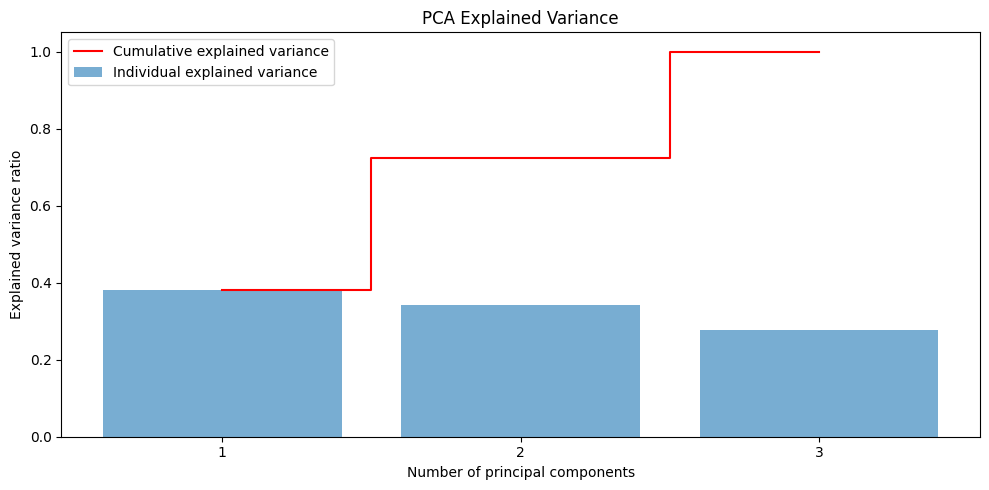

Number of components to explain 90% variance: 3
Shape of transformed data: (231637, 3)


In [83]:
# Select features
features = [
    'inter_doy_sin_smooth',
    'inter_doy_cos_smooth',
    'inter_strength'
]

X = df_recipes_with_season_features[features].copy()

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit PCA without specifying components first
pca_full = PCA()
pca_full.fit(X_scaled)

# Explained variance for each component
explained_var = pca_full.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

# Plot explained variance and cumulative explained variance
plt.figure(figsize=(10, 5))

plt.bar(range(1, len(explained_var)+1), explained_var, alpha=0.6, label='Individual explained variance')
plt.step(range(1, len(cumulative_var)+1), cumulative_var, where='mid', label='Cumulative explained variance', color='red')
plt.xlabel('Number of principal components')
plt.ylabel('Explained variance ratio')
plt.title('PCA Explained Variance')
plt.xticks(range(1, len(explained_var)+1))
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Determine optimal number of components
# Option 1: Choose number of components to explain >= 90% variance
threshold = 0.90
best_n_components = np.argmax(cumulative_var >= threshold) + 1
print(f"Number of components to explain {threshold*100:.0f}% variance: {best_n_components}")

# Re-fit PCA with the chosen number of components
pca = PCA(n_components=best_n_components)
X_pca = pca.fit_transform(X_scaled)

print(f"Shape of transformed data: {X_pca.shape}")

## Conclusion

### Definitions

Submission date:
- `submitted_doy_sin`: sine transformation of the recipe's submission day-of-year, encoding its seasonal position.
- `submitted_doy_cos`: cosine transformation of the recipe's submission day-of-year, used with sine to represent season cyclically.

Average seasonal timing of interactions:
- `inter_doy_sin_smooth`: smoothed sine transformation of the interaction day-of-year.
- `inter_doy_cos_smooth`: smoothed cosine transformation of the interaction day-of-year.
- `inter_strength`: the norm of the smoothed interaction sine-cosine vector, measuring the strength of seasonal concentration.

### Approach 2 clustering analysis

**6 clusters with `submitted_doy_sin`, `submitted_doy_cos`, `inter_doy_sin_smooth`, `inter_doy_cos_smooth`, `inter_strength`:**

- Clusters 0–2 are mainly distinguished by their `submitted` season, while their interaction seasonality is weak. These are likely recipes with small sample sizes or sparse interaction activity.

- Clusters 3–5 differ not only in their submission season but also show clear seasonal preferences in user interactions:
    - Cluster 3: interactions peak in spring
    - Cluster 4: interactions peak in summer
    - Cluster 5: interactions peak in winter (with strong seasonal strength)

- Clusters 4 and 5 have high `inter_strength` values, indicating that these clusters represent strongly seasonal recipe types, such as holiday recipes or summer-special dishes.

Silhouette Score=0.23

**4 clusters with `inter_doy_sin_smooth`, `inter_doy_cos_smooth`, `inter_strength`:**

- Cluster 0: No clear seasonal preference. This group represents weak seasonality or noise.
- Cluster 1: Slightly biased toward spring, but the strength is low.
- Cluster 2: Negative cos corresponds to the summer direction, with relatively high strength. This is a summer-preference cluster.
- Cluster 3: Positive cos corresponds to the winter direction, with relatively high strength. This is a winter-preference cluster.

Silhouette Score=0.33

### Feature proposal

In [88]:
df_recipes_with_season_features[[
    'id',
    'submitted_doy_sin',
    'submitted_doy_cos',
    'inter_doy_sin_smooth',
    'inter_doy_cos_smooth',
    'inter_strength'
]].head()

,id,submitted_doy_sin,submitted_doy_cos,inter_doy_sin_smooth,inter_doy_cos_smooth,inter_strength
0,137739,-0.967938,-0.251190,-0.022054,0.090011,0.092673
1,31490,0.247022,-0.969010,-0.049724,-0.149662,0.157706
2,112140,0.821477,0.570242,-0.066967,0.062344,0.091495
3,59389,0.976011,-0.217723,0.122043,-0.077462,0.144551
4,44061,-0.914128,0.405426,-0.054627,-0.036020,0.065433


In [89]:
df_recipes_with_season_features[[
    'id',
    'inter_doy_sin_smooth',
    'inter_doy_cos_smooth',
    'inter_strength'
]].head()

,id,inter_doy_sin_smooth,inter_doy_cos_smooth,inter_strength
0,137739,-0.022054,0.090011,0.092673
1,31490,-0.049724,-0.149662,0.157706
2,112140,-0.066967,0.062344,0.091495
3,59389,0.122043,-0.077462,0.144551
4,44061,-0.054627,-0.036020,0.065433
